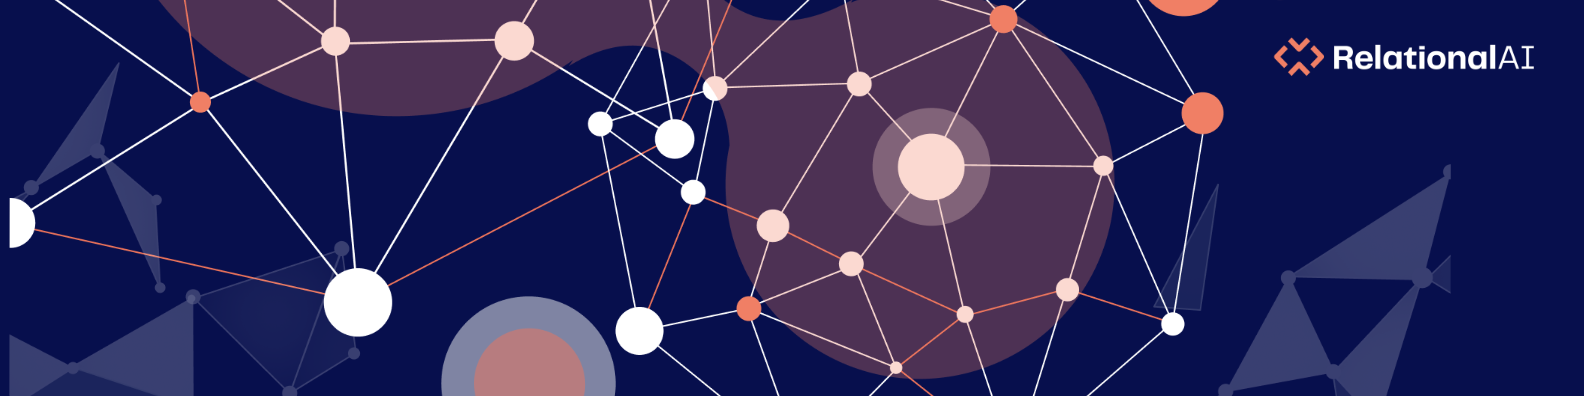

#  Jaccard Similarity

The `jaccard_similarity` function computes the [Jaccard Similarity coefficient](https://en.wikipedia.org/wiki/Jaccard_index) between two nodes of the graph. The measure is a defined for two sets as the size of the intersection of the sets divided by the size of their union. For graph nodes, the sets it is looking at are the edges connected to them. It's a useful metric to identify how similar nodes are based on their common edges.

Let us look at an example graph, where people are connected to languages they know, and use the algorithm to identify who are the people similar to each other.

First, we need to import the `relationalai` library and define our model, which we call `MyJaccardSimilarity`. We also define three types called `Person`, `Language` and `Similarity`.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import alias
from relationalai.std import aggregates
import colorsys
import math

model = rai.Model("MyJaccardSimilarity")

# Model will hold these types:

# Represent nodes we will be comparing to each other
Person = model.Type("Person")

# Represent the nodes Person nodes are connected to, which we will use to compare
Language = model.Type("Language")

# Represent pairs of Person nodes and how similar they are
Similarity = model.Type("Similarity")

## Let's add some data to our model

The data that we use in this notebook represents a school computer science club with several members, each with their own set of interests in different programming languages. We'll consider the interests of the members as sets of programming languages. 

We first create a dictionary with names of people and the programming languages that they are interested in. Then we iterate over the dictionary to create objects of type `Person` with a `name` property. We also create an object of type `Language` for each new language that we encounter, and set the `knows` property accordingly.

In [3]:
data = {
    "Sarah": ["Python", "Java", "Javascript"],
    "Alex": ["Python", "Julia", "C"],
    "Michael": ["Java", "C++", "R", "Javascript"],
    "Emily": ["Python", "Java", "Javascript", "CSS"],
    "Max": ["Javascript", "HTML", "CSS"],
}

with model.rule(dynamic = True):
    for person_name, languages in data.items():
        # Create a Person object
        person = Person.add(name = person_name)
        for lang in languages:
            language = Language.add(name = lang)
            # Connect the Person object to the Language object
            person.knows.add(language)

## Creating the graph
Let's start by creating a `graph` with `Node` and `Edge` collections. We add all `Person` and `Language` instances as nodes and the `knows` property is used to form the edges in our graph.

In [4]:
# Create graph
graph = Graph(model, undirected = True)
Node, Edge = graph.Node, graph.Edge

# add all Person and Language instances as Nodes
Node.extend(Person)
Node.extend(Language)

# The `knows` property is used to create edges between people and languages
Edge.extend(Person.knows)

## Running the algorithm
Let's add a rule that calculates for every node of the graph that represents a person the similarity score to another person based on the languages that they know. To derive this value for each node using the Jaccard Similarity algorithm, we can simply use `graph.compute.jaccard_similarity()`.

We define two `Person` objects, `p1` and `p2` and add a condition that `p1` and `p2` are different people. We use `p1 < p2` to ensure that we don't double count the similarity between the same two people. `<` is comparing the entities based on their unique identifiers in the model. Finally, we're calculate the Jaccard similarity between each pair of people based on the languages they know.

In [5]:
# Compute Jaccard similarity between `Person` nodes based on connections to `Language` nodes
with model.rule():
    p1 = Person()
    p2 = Person()
    p1 < p2
    similarity_score = graph.compute.jaccard_similarity(p1, p2)
    Similarity.add(person1 = p1, person2 = p2).set(score = similarity_score)

## Visualizing the results
Let's visualize our graph, to better understand the results. We use `Graph(model).visualize()` to visualize a graph.

For visualization purposes, in addition to the `Person` to `Language` nodes connections we have, we also want to draw edges between similar `Person` nodes and color them red based on the Jaccard similarity score. The darker and thicker the edge, the higher the Jaccard similarity. To do that, we create a new graph, which this time will have `Edges` also added from `Similarity` instances we created.

We also color the nodes based on their type: `Person` nodes are displayed in blue and `Language` nodes in pink.

In [6]:
similarity_graph = Graph(model, undirected = True)

# Add all Person and Language instances as Nodes and assign `name` and `node_type` properties (for displaying)
similarity_graph.Node.extend(Person, name = Person.name, node_type = "person")
similarity_graph.Node.extend(Language, name = Language.name, node_type = "language")

similarity_graph.Edge.extend(Person.knows)

# Add Similarity instances as Edges and assign `similarity` property
with model.rule():
    s = Similarity()
    similarity_graph.Edge.add(s.person1, s.person2, similarity = s.score)

def get_gradient_color(value):
    rgb = colorsys.hsv_to_rgb(1, value, 1)
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

similarity_graph.visualize(three = False, node_size_factor = 3, style = {
    "node": {
        "color": lambda n: {"person": "blue", "language": "pink"}.get(n["node_type"]),
        "label": lambda n: n["name"],
    },
    "edge": {
        "color": lambda e: get_gradient_color(e['similarity']) if e.get('similarity') else "green",
        "hover": lambda e: e.get("similarity"),
        "size": lambda e: math.exp(3*e.get('similarity', 0)),
    }
}).display(inline = True)

## Querying the Graph
Graph Nodes, Edges and their properties are queried using `model.query()` context and `graph.Node()` or `graph.Edge()` types.

Alternatively, the entire graph representation can be fetched using `Graph(model).fetch()` (we do not recommend doing this on a large graph though). This returns a dictionary with two keys, `nodes` and `edges`, that represents the entire graph. 

In [7]:
with model.query() as select:
    p1 = Person()
    p2 = Person()
    e = similarity_graph.Edge(p1, p2)
    response = select(alias(p1.name, 'person 1'), alias(p2.name, 'person 2'), alias(e.similarity, 'similarity'))

response

### Let's find out who are the two people most similar in their languages interest

In [8]:
with model.query() as select:
    s = Similarity()
    aggregates.rank_desc(s.score) == 1
    response = select(alias(s.person1.name, 'person 1'), alias(s.person2.name, 'person 2'), s.score)

response